In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanicdataset/TitanicData.csv


***Prediction for Survival Rate***

In [2]:
#start pyspark session
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 15.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805913 sha256=0779e49bcaba3fb3032cfe97488a6c67dd3623ef895f3786d3986cd39241ac06
  Stored in directory: /root/.cache/pip/wheels/e7/7a/38/336d4a32e61c410ce83bf854593a1955d2d987060c0f26d373
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
#import all required packages
import pandas as pd #what does this do - to replace missing values
import matplotlib.pyplot as plt #what does this do - draw figures/graphs - to prove outlier detection
import seaborn as sns #what does this do - outlier detection 
import numpy as np #what does this do - outlier detection

**Step 1: Data Preprocessing**

In [4]:
#load dataset
data = pd.read_csv("/kaggle/input/titanicdataset/TitanicData.csv")
#show dataset
print(data.shape)
print(data)
data.info()

(891, 12)
     PassengerId  Pclass                                               Name  \
0              1       3                            Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2              3       3                             Heikkinen, Miss. Laina   
3              4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                           Allen, Mr. William Henry   
..           ...     ...                                                ...   
886          887       2                              Montvila, Rev. Juozas   
887          888       1                       Graham, Miss. Margaret Edith   
888          889       3           Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                              Behr, Mr. Karl Howell   
890          891       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch          

Based on the above data, this is my deduction and my next planned steps:

* The shape of the dataset shows that there is 891 records with 12 categories/columns
* The data info shows that there are 2 categories of type float, 5 categories of type int and 5 categories of type object.

Columns with missing information include:

* Age = 714/891 records - as majority of data is available the missing values will be predicted via age mean.
* Cabin = 204/891 records - as most of the data is missing and the information this category provides is unuseful, the column will be dropped.
* Embarked = 889/891 - as only 2 records are missing, those will be dropped to reduce the dataset to 889 records.

In [5]:
#first removing data that is uneccesary

data2 = data.drop(columns = ['Cabin'])
data2 = data2.dropna(subset=['Embarked'])

print(data2.shape)
print(data2)
data2.info()

(889, 11)
     PassengerId  Pclass                                               Name  \
0              1       3                            Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2              3       3                             Heikkinen, Miss. Laina   
3              4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                           Allen, Mr. William Henry   
..           ...     ...                                                ...   
886          887       2                              Montvila, Rev. Juozas   
887          888       1                       Graham, Miss. Margaret Edith   
888          889       3           Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                              Behr, Mr. Karl Howell   
890          891       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch          

In [6]:
#to fill in Age where there is no value
print(data2['Age'])
data2['Age'] = data2['Age'].fillna(data2['Age'].mean().round(0))
print(data2['Age'])

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 889, dtype: float64
0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    30.0
889    26.0
890    32.0
Name: Age, Length: 889, dtype: float64


In [7]:
#check data if clean
print(data2)
data2.info()
dataCheck = data2.loc[data2.isnull().any(axis=1)]
print(dataCheck)

     PassengerId  Pclass                                               Name  \
0              1       3                            Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2              3       3                             Heikkinen, Miss. Laina   
3              4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                           Allen, Mr. William Henry   
..           ...     ...                                                ...   
886          887       2                              Montvila, Rev. Juozas   
887          888       1                       Graham, Miss. Margaret Edith   
888          889       3           Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                              Behr, Mr. Karl Howell   
890          891       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket  

There are no more records with Non Null values. Next will be transforming values Sex and Embarked from object type to int type

In [8]:
#make sex and embarked columns numerical
data2['Sex'] = data2['Sex'].map( {'male': 1,'female': 0} )
data2['Embarked'] = data2['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Pclass       889 non-null    int64  
 2   Name         889 non-null    object 
 3   Sex          889 non-null    int64  
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Ticket       889 non-null    object 
 8   Fare         889 non-null    float64
 9   Embarked     889 non-null    int64  
 10  Survived     889 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 83.3+ KB


All appropriate columns are now numerical. Next step is to check for outliers

In [9]:
data2.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,2.311586,0.649044,29.713352,0.524184,0.382452,32.096681,0.362205,0.382452
std,256.998173,0.834700,0.477538,12.969135,1.103705,0.806761,49.697504,0.636157,0.486260
min,1.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,446.000000,3.000000,1.000000,30.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,668.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,891.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,1.000000


Based on above results, PassengerID, Pclass, Sex, Embarked and Survived don't have any outliers but the last 3 will be checked again.

Rows to ensure they don't have any outliers are Age, SibSp, Parch and Fare

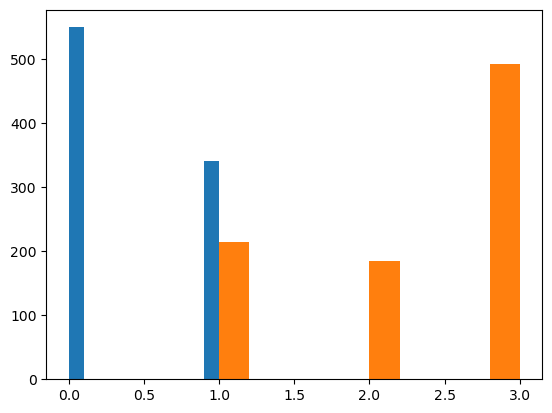

In [10]:
fig = plt.hist(data2['Survived'])
fig = plt.hist(data2['Pclass'])

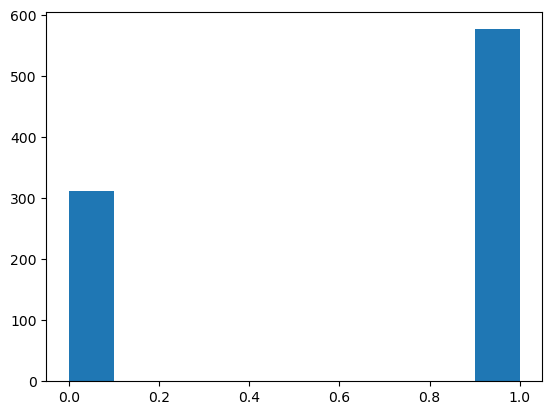

In [11]:
fig = plt.hist(data2['Sex'])

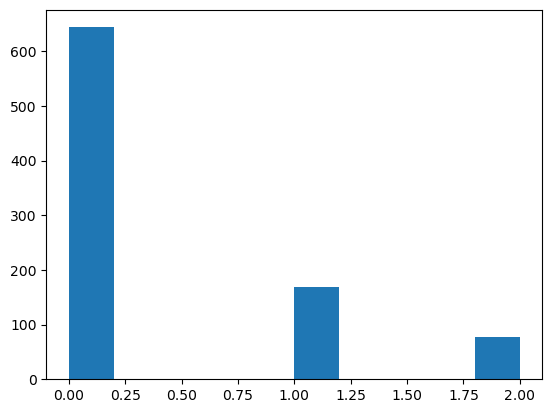

In [12]:
fig = plt.hist(data2['Embarked'])

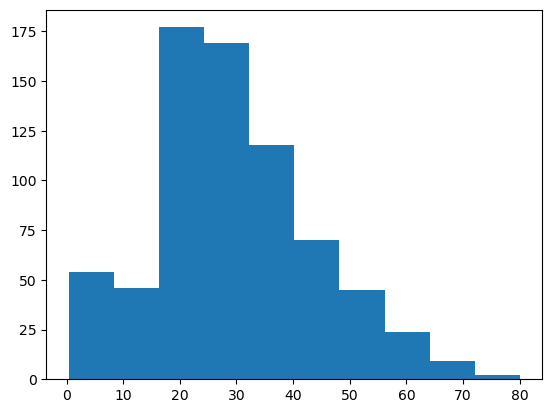

In [13]:
fig = plt.hist(data['Age'])

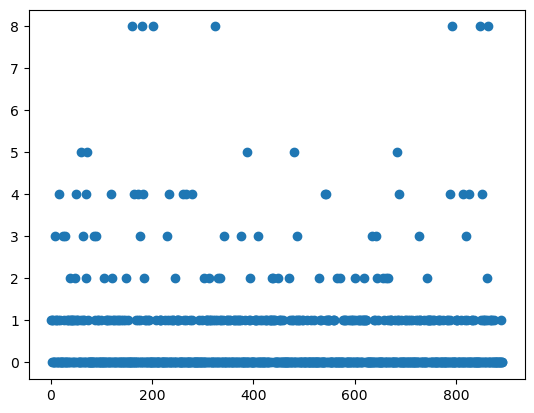

In [14]:
fig = plt.scatter(data['PassengerId'], data['SibSp']) 
#multiple values for 8 - need to determine how many to make proper judgement if outlier

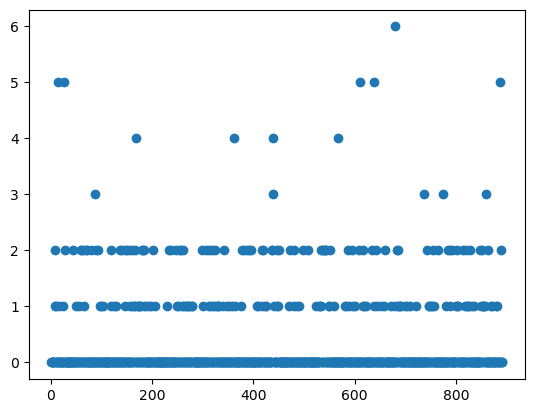

In [15]:
fig = plt.scatter(data['PassengerId'],data['Parch']) 
#6 is definitely outlier - to be removed

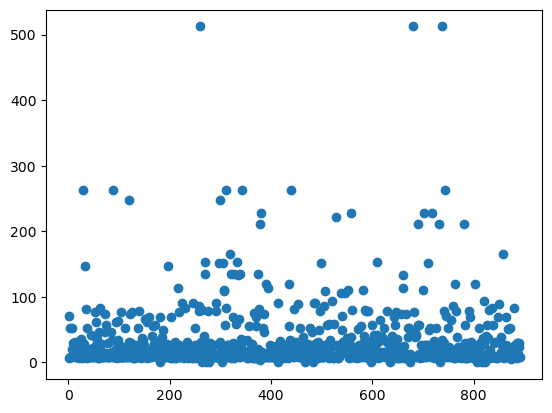

In [16]:
fig = plt.scatter(data['PassengerId'],data['Fare']) 
#Going to call 500 an outlier, will make it mean value

Assumptions based on the graph:

* PassengerId - No need to change, numbering is sequential
* Pclass - No need to change, numbering is categorical, 1 2 3 and no other information
* Sex - No need to change, numbering is categorical, 0(female), 1(male)
* Age - No need to change, the values seems to be evenly spread out and there doesn't seem to be any unreleastic outliers
* SibSp - While it might seem like there is an outlier, the column wont be used for the prediction so I won't worried about
* Parch - While it might seem like there is an outlier, the column wont be used for the prediction so I won't worried about
* Fare - While it might seem like there is an outlier, the column wont be used for the prediction so I won't worried about
* Embarked - No need to change, numbering is categorical, 0(S), 1(C), 2(Q)
* Survived - No need to change, numbering is categorical, 0(No), 1(Yes)

Data cleaning is officially completed.

I don't believe data reduction is necessary for this as it will allow for better result to have more data, and there has already been some reduction done with the cleaning stage.

Next step is Data Transformation

To predict Survival Rate I would suggest the following columns, which will allow for better filtering (?not sure if it is the right word).

* Pclass - to predict survival rate based on class
* Sex - to predict survival rate based on gender
* Age - to predict survival rate based on age
* Embarked - to predict survival rate based on location

I assume I will also need Survived for the prediction.

**Step 2: Extract/Select features to describe data**

In [17]:
#what do these do - start pyspark session and configuration
from pyspark import SparkConf, SparkContext 
from pyspark.sql import SparkSession, SQLContext 
spark = SparkSession.builder.master("local[2]").appName("lg").getOrCreate()
sc = spark.sparkContext

cleanedData = spark.createDataFrame(data2)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/23 10:38:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [18]:
from pyspark.ml.feature import VectorAssembler as vAss, StringIndexer as sInd #what do these do - feature transformation
from pyspark.ml import Pipeline as pl#what does this do - feature transformation

In [19]:
cleanedData.show()

+-----------+------+--------------------+---+----+-----+-----+----------------+-------+--------+--------+
|PassengerId|Pclass|                Name|Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Survived|
+-----------+------+--------------------+---+----+-----+-----+----------------+-------+--------+--------+
|          1|     3|Braund, Mr. Owen ...|  1|22.0|    1|    0|       A/5 21171|   7.25|       0|       0|
|          2|     1|Cumings, Mrs. Joh...|  0|38.0|    1|    0|        PC 17599|71.2833|       1|       1|
|          3|     3|Heikkinen, Miss. ...|  0|26.0|    0|    0|STON/O2. 3101282|  7.925|       0|       1|
|          4|     1|Futrelle, Mrs. Ja...|  0|35.0|    1|    0|          113803|   53.1|       0|       1|
|          5|     3|Allen, Mr. Willia...|  1|35.0|    0|    0|          373450|   8.05|       0|       0|
|          6|     3|    Moran, Mr. James|  1|30.0|    0|    0|          330877| 8.4583|       2|       0|
|          7|     1|McCarthy, Mr. Tim...|  1|5

In [20]:
Assembler_features = vAss(inputCols = ['Pclass', 'Sex','Age','Embarked'], outputCol = 'features')
indexLabel = sInd(inputCol = "Survived", outputCol = "label")
data_prep_pipe = pl(stages = [Assembler_features, indexLabel])
assembler = data_prep_pipe.fit(cleanedData)
AsscleanedData = assembler.transform(cleanedData)
AsscleanedData = AsscleanedData.select(['features', 'label'])
AsscleanedData.show()

+------------------+-----+
|          features|label|
+------------------+-----+
|[3.0,1.0,22.0,0.0]|  0.0|
|[1.0,0.0,38.0,1.0]|  1.0|
|[3.0,0.0,26.0,0.0]|  1.0|
|[1.0,0.0,35.0,0.0]|  1.0|
|[3.0,1.0,35.0,0.0]|  0.0|
|[3.0,1.0,30.0,2.0]|  0.0|
|[1.0,1.0,54.0,0.0]|  0.0|
| [3.0,1.0,2.0,0.0]|  0.0|
|[3.0,0.0,27.0,0.0]|  1.0|
|[2.0,0.0,14.0,1.0]|  1.0|
| [3.0,0.0,4.0,0.0]|  1.0|
|[1.0,0.0,58.0,0.0]|  1.0|
|[3.0,1.0,20.0,0.0]|  0.0|
|[3.0,1.0,39.0,0.0]|  0.0|
|[3.0,0.0,14.0,0.0]|  0.0|
|[2.0,0.0,55.0,0.0]|  1.0|
| [3.0,1.0,2.0,2.0]|  0.0|
|[2.0,1.0,30.0,0.0]|  1.0|
|[3.0,0.0,31.0,0.0]|  0.0|
|[3.0,0.0,30.0,1.0]|  1.0|
+------------------+-----+
only showing top 20 rows



Data Transformation completed, as well as step 2

**Conduct the classification on the extracted/selected features**

#logistic regression

In [21]:
#splitting dataset into training and testing sets.
(training, testing) = AsscleanedData.randomSplit([0.7,0.3])
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

In [22]:
survivorPredLog = lr.fit(training)

In [23]:
testResultsLR = survivorPredLog.transform(testing)
testResultsLR.show()

+------------------+-----+--------------------+--------------------+----------+
|          features|label|       rawPrediction|         probability|prediction|
+------------------+-----+--------------------+--------------------+----------+
|[1.0,0.0,17.0,1.0]|  1.0|[-3.1177317232361...|[0.04238173554495...|       1.0|
|[1.0,0.0,23.0,0.0]|  1.0|[-2.5370072686437...|[0.07330421234330...|       1.0|
|[1.0,0.0,23.0,1.0]|  1.0|[-2.9071831715132...|[0.05179961343720...|       1.0|
|[1.0,0.0,24.0,1.0]|  1.0|[-2.8720917462261...|[0.05355053723252...|       1.0|
|[1.0,0.0,30.0,1.0]|  1.0|[-2.6615431945032...|[0.06528110530065...|       1.0|
|[1.0,0.0,30.0,1.0]|  1.0|[-2.6615431945032...|[0.06528110530065...|       1.0|
|[1.0,0.0,32.0,1.0]|  1.0|[-2.5913603439290...|[0.06969652799536...|       1.0|
|[1.0,0.0,35.0,0.0]|  1.0|[-2.1159101651979...|[0.10756002763620...|       1.0|
|[1.0,0.0,38.0,1.0]|  1.0|[-2.3808117922061...|[0.08464764489298...|       1.0|
|[1.0,0.0,41.0,1.0]|  1.0|[-2.2755375163

In [24]:
from pyspark.mllib.evaluation import MulticlassMetrics
PredicationAndLabel = testResultsLR['prediction','label']
PredicationAndLabel.show()
multiMetrics = MulticlassMetrics(PredicationAndLabel.rdd)
precisionScore = multiMetrics.weightedPrecision
recallScore = multiMetrics.weightedRecall
accuracyScore = multiMetrics.accuracy
print(precisionScore)
print(recallScore)
print(accuracyScore)
multiMetrics.confusionMatrix().toArray()

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  0.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  0.0|
|       1.0|  0.0|
|       0.0|  1.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 20 rows



/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


0.78640790655885
0.7886792452830189
0.7886792452830189


array([[141.,  22.],
       [ 34.,  68.]])

linear regression

In [25]:
(training, testing) = AsscleanedData.randomSplit([0.7,0.3])
from pyspark.ml.regression import LinearRegression
linr = LinearRegression(featuresCol = 'features', labelCol= 'label')
survivedPredictor = linr.fit(training)

23/03/23 10:38:45 WARN Instrumentation: [5c90d415] regParam is zero, which might cause numerical instability and overfitting.


In [26]:
test_results = survivedPredictor.transform(testing)
test_results.select("prediction", "label", "features").show(5)

+------------------+-----+------------------+
|        prediction|label|          features|
+------------------+-----+------------------+
|1.0786179531675977|  0.0| [1.0,0.0,2.0,0.0]|
|1.0056136676561476|  1.0|[1.0,0.0,14.0,0.0]|
|1.0425112210078888|  1.0|[1.0,0.0,16.0,1.0]|
|0.9447767630632722|  1.0|[1.0,0.0,24.0,0.0]|
|0.9938416973335886|  1.0|[1.0,0.0,24.0,1.0]|
+------------------+-----+------------------+
only showing top 5 rows



In [27]:
test_result = survivedPredictor.evaluate(testing)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.372511


k-means

In [28]:
# 4.3 StandardScaler
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(AsscleanedData)
data_scale_output=data_scale.transform(AsscleanedData)
data_scale_output.show(2)

+------------------+-----+--------------------+
|          features|label|        standardized|
+------------------+-----+--------------------+
|[3.0,1.0,22.0,0.0]|  0.0|[3.59410662015210...|
|[1.0,0.0,38.0,1.0]|  1.0|[1.19803554005070...|
+------------------+-----+--------------------+
only showing top 2 rows



In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction',
featuresCol='standardized',metricName='silhouette',distanceMeasure='squaredEuclidean')
for i in range(2,10):
 KMeans_=KMeans(featuresCol='standardized', k=i)
 KMeans_fit=KMeans_.fit(data_scale_output)
 output=KMeans_fit.transform(data_scale_output)
 score=evaluator.evaluate(output)
 silhouette_score.append(score)
 print("Silhouette Score:",score)

Silhouette Score: 0.41292024919415066
Silhouette Score: 0.4675981140588185
Silhouette Score: 0.4683442424966296
Silhouette Score: 0.5310634744940074
Silhouette Score: 0.5133596874712587
Silhouette Score: 0.536033757998466
Silhouette Score: 0.4934993513777766
Silhouette Score: 0.4698825683569116


In [30]:
# Trains a k-means model.
KMeans_=KMeans(featuresCol='features', k=9)
KMeans_Model=KMeans_.fit(data_scale_output)
# Make predictions
KMeans_prediction=KMeans_Model.transform(data_scale_output)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(KMeans_prediction)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.68612000835689
